# 20250704

# Zero-Shot Cell Type Classification with LangCell: A Multimodal Approach

## Project Description

This notebook implements and evaluates a zero-shot cell type classification system using LangCell, a multimodal framework that combines biomedical language models with single-cell genomics data. The approach leverages both similarity-based matching and cross-modal classification to predict cell types without requiring task-specific training data.

## Key Components

### Models and Architecture
- **Cell Encoder**: Custom BERT model fine-tuned on single-cell data with specialized pooling layer
- **Text Encoder**: PubMedBERT (biomedical language model) for processing cell type descriptions
- **Cross-Modal Classification**: CTM head that combines cell embeddings with textual descriptions
- **Ensemble Prediction**: Weighted combination of similarity-based and cross-modal predictions

### Methodology
1. **Data Preparation**: Load and preprocess single-cell dataset with cell type annotations
2. **Text Encoding**: Convert cell type descriptions into normalized embeddings using PubMedBERT
3. **Cell Encoding**: Generate cell embeddings using the specialized cell BERT model
4. **Dual Prediction Strategy**:
   - **Similarity Matching**: Cosine similarity between cell and text embeddings
   - **Cross-Modal Classification**: CTM model with cell-text attention mechanisms
5. **Ensemble Integration**: Combine predictions using weighted averaging
6. **Evaluation**: Comprehensive performance analysis with confusion matrices and UMAP visualization

## Expected Outcomes
- Zero-shot cell type classification performance metrics
- Visual evaluation through UMAP embeddings showing prediction quality
- Detailed confusion matrix analysis for model interpretability

## Dependencies
- PyTorch ecosystem (transformers, torch)
- Single-cell analysis tools (scanpy, anndata)
- Biomedical datasets and models (PubMedBERT, custom cell encoders)
- Evaluation and visualization libraries (sklearn, matplotlib, seaborn)

---

# Sets up the environment and imports all necessary libraries for cell classification tasks

In [1]:
# Set GPU device (using GPU 0)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Dataset and data handling
from datasets import load_from_disk
import torch.nn as nn, torch.nn.functional as F
import torch, json

# BERT model and tokenizer
from transformers import BertTokenizer, BertModel

# Custom utilities for medical/biological BERT and data processing
from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification

# Training and data loading utilities
from tqdm import tqdm
from torch.utils.data import DataLoader

# Single-cell analysis libraries
import anndata as ad, scanpy as sc

/cloud-home/U1013680/.magellan/conda/envs/scvi_python_3_10/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/cloud-home/U1013680/.magellan/conda/envs/scvi_python_3_10/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/cloud-home/U1013680/.magellan/conda/envs/scvi_python_3_10/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/cloud-home/U1013680/.magellan/conda/envs/scvi_python_3_10/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/cloud-hom

# Custom Pooler and Model Setup for Cell Classification

In [2]:
# This cell defines a custom pooler layer and loads the pre-trained LangCell BERT model

class Pooler(nn.Module):
    """
    Custom pooler that applies a linear projection to the [CLS] token representation
    and normalizes the output for downstream cell classification tasks
    """
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        # Create linear projection layer from hidden_size to projection dimension
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        # Load pre-trained projection weights
        self.proj.load_state_dict(torch.load(pretrained_proj))
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # Extract [CLS] token representation (first token)
        pooled_output = hidden_states[:, 0]
        # Apply projection and L2 normalization
        pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
        return pooled_output

# Load pre-trained LangCell BERT model
model = BertModel.from_pretrained('/cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/cell_bert')

# Replace default pooler with custom pooler using pre-trained projection weights
model.pooler = Pooler(
    model.config, 
    pretrained_proj='/cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/cell_proj.bin', 
    proj_dim=256
)

# Extract projection layer for potential separate use
proj = model.pooler.proj

# Move model to GPU
model = model.to("cuda")

Some weights of BertModel were not initialized from the model checkpoint at /cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Text Encoder Setup for Biomedical Language Processing

In [3]:
# This cell configures the text encoder component with PubMedBERT and custom tokenization

# Load biomedical pre-trained model identifier
text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'

# Initialize tokenizer with biomedical vocabulary
tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)

# Add custom special tokens for encoding/decoding tasks
tokenizer.add_special_tokens({'bos_token':'[DEC]'})  # Beginning of sequence token for decoding
tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})  # Encoding token
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  # Store encoding token ID for easy access

# Load pre-trained text encoder (biomedical BERT variant)
text_encoder = MedBertModel.from_pretrained(
    '/cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/text_bert', 
    add_pooling_layer=True
)

# Replace default pooler with custom pooler using pre-trained text projection weights
text_encoder.pooler = Pooler(
    text_encoder.config, 
    pretrained_proj='/cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/text_proj.bin', 
    proj_dim=256
)

# Move text encoder to GPU
text_encoder = text_encoder.to("cuda")

# Initialize cell type mapping (CTM) classification head
ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)  # Binary classification head

# Load pre-trained CTM head weights
ctm_head.load_state_dict(torch.load('/cloud-data/digitalrnd-projects-ireland/SC_LLM/Magellan/model/langcell/ckpt/ctm_head.bin'))

# Move CTM head to GPU
ctm_head = ctm_head.to("cuda")

# Encoding and Classification Functions

In [4]:
# This cell defines the main inference functions for text encoding, cell encoding, and cell type mapping

def text_encode(text):
    """
    Encode text input using the biomedical BERT text encoder
    
    Args:
        text: Input text string or list of strings
    
    Returns:
        torch.Tensor: Normalized pooled text embeddings
    """
    # Tokenize text with padding and truncation
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    
    # Get pooled text representation from text encoder
    text = text_encoder(**text).pooler_output
    
    # Note: Additional normalization with text projector is commented out
    # text = F.normalize(model.text_projector(text))
    
    return text

def cell_encode(cell_input_ids, cell_atts):
    """
    Encode cell data using the cell BERT model
    
    Args:
        cell_input_ids: Tokenized cell input IDs
        cell_atts: Cell attention masks
    
    Returns:
        tuple: (last_hidden_state, pooler_output) - Full sequence and pooled cell embeddings
    """
    # Forward pass through cell BERT model
    cell = model(cell_input_ids.to("cuda"), cell_atts.to("cuda"))
    
    # Extract last hidden states (full sequence) and pooled output
    cell_last_h = cell.last_hidden_state
    cell_pooler = cell.pooler_output
    
    return cell_last_h, cell_pooler

def ctm(text, cell_emb, cell_atts):
    """
    Cell Type Mapping (CTM) - Cross-modal classification of cell types based on text and cell embeddings
    
    Args:
        text: Text description or query
        cell_emb: Cell embeddings from cell encoder
        cell_atts: Cell attention masks
    
    Returns:
        torch.Tensor: Classification probabilities (positive class probability)
    """
    # Tokenize input text
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    
    # Cross-modal encoding: text encoder with cell embeddings as context
    output = text_encoder(
        **text,
        encoder_hidden_states=cell_emb.to("cuda"),  # Use cell embeddings as encoder context
        encoder_attention_mask=cell_atts.to("cuda"),  # Cell attention masks
        return_dict=True,
        mode='multimodal',  # Enable multimodal processing
    )
    
    # Classification head on [CLS] token representation
    logits = ctm_head(output.last_hidden_state[:, 0, :])
    
    # Apply softmax and extract positive class probability
    logits = F.softmax(logits, dim=-1)[..., 1]  # Shape: [batch_size]
    
    return logits

# Dataset Loading and Preprocessing

In [5]:
# This cell loads the dataset, creates a subset for testing, and standardizes the cell type label column

# Load dataset from disk
dataset = load_from_disk("/cloud-home/U1013680/temp/")

# Create a shuffled subset of 10,000 samples for testing/validation
dataset_sub = dataset.shuffle(seed=1).select(range(10000))

# Find the cell type label column (datasets may use different naming conventions)
for label_name in ["celltype", "cell_type", "str_labels", "labels"]:
    if label_name in dataset_sub.column_names:
        break

# Standardize column name to "celltype" if it's named differently
if label_name != "celltype":
    dataset_sub = dataset_sub.rename_column(label_name, "celltype")

Loading dataset from disk:   0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
dataset_sub

Dataset({
    features: ['input_ids', 'sampleID', 'level_1_annot', 'level_2_annot', 'level_3_annot', 'n_counts', 'cell_type_ontology_term_id', 'sourceID', 'study', 'donorID_unified', 'donor_category', 'donor_disease', 'organ_unified', 'age_unified', 'sample_type', 'sample_category', 'sample_retrieval', 'tissue_fraction', 'cell_fraction_unified', 'cell_sorting', 'organ_groups', 'control_vs_disease', 'technology', 'disease', 'sex', 'celltype'],
    num_rows: 10000
})

In [7]:
print(set(dataset_sub['celltype']))

{'B and B plasma', 'Epithelial', 'Neural', 'Endothelial', 'Myeloid', 'T and NK cells', 'Mesenchymal'}


# Cell Type Description Encoding and Mapping Setup

In [8]:
# This cell loads cell type descriptions, encodes them into embeddings, and creates type mappings

import json

# Extract unique cell types from the dataset
types = list(set(dataset_sub['celltype']))

# Load cell type descriptions from JSON file
type2text = json.load(open('/cloud-home/U1013680/workplace/python/projects/single_Cell_data/gutcellatlas/langcell/LangCell-annotation-zeroshot/cell_type_description.json'))

# Get text descriptions for each cell type
texts = [type2text[typename] for typename in types]

# Encode all cell type descriptions into embeddings
with torch.no_grad():
    # Encode each text description and concatenate into a matrix
    text_embs = torch.cat([text_encode(text) for text in texts], 0).T.cuda()  # Shape: 256 x N_types
    
# Ensure text embeddings don't require gradients (frozen for inference)
text_embs.requires_grad = False

# Create mapping from cell type names to numerical indices
type2num = dict([(type, i) for i, type in enumerate(types)])

# Dataset Preparation and DataLoader Setup

In [9]:
# This cell converts cell type labels to numerical IDs and prepares the dataset for batch processing

def classes_to_ids(example):
    """
    Convert cell type string labels to numerical IDs
    
    Args:
        example: Dataset example with 'celltype' field
    
    Returns:
        dict: Example with added 'label' field containing numerical ID
    """
    example["label"] = type2num[example["celltype"]]
    return example

# Apply label conversion to the entire dataset
testdataset = dataset_sub.map(classes_to_ids, num_proc=1)

# Remove unnecessary columns, keeping only input_ids and labels
remove_columns = testdataset.column_names
remove_columns.remove('input_ids')  # Keep tokenized cell data
remove_columns.remove('label')      # Keep numerical labels
testdataset = testdataset.remove_columns(remove_columns)

# Configure batch processing parameters
batchsize = 32

# Initialize data collator for cell classification tasks
collator = DataCollatorForCellClassification()

# Create DataLoader for batch processing during inference
dataloader = DataLoader(
    testdataset, 
    batch_size=batchsize, 
    collate_fn=collator, 
    shuffle=False  # Maintain order for evaluation
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
labels = torch.tensor(testdataset['label'])
print(labels)

tensor([5, 6, 5,  ..., 3, 6, 1])


# Model Inference and Evaluation

In [11]:
# This cell performs zero-shot cell type prediction using both similarity matching and cross-modal classification

# Initialize storage arrays for results
cell_embs = torch.zeros(len(dataset_sub), 256)  # Store cell embeddings
model.eval()  # Set cell encoder to evaluation mode
text_encoder.eval()  # Set text encoder to evaluation mode

# Initialize prediction and logit storage
preds = torch.zeros(len(dataset_sub))  # Final predictions
sim_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])  # Similarity-based logits
ctm_logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])  # Cross-modal logits
logits = torch.zeros(len(dataset_sub), text_embs.shape[-1])  # Combined logits
labels = torch.tensor(testdataset['label'])  # True labels for evaluation

# Perform inference without gradient computation
with torch.no_grad():
    for i, d in tqdm(enumerate(dataloader)):
        # Encode cell data
        cell_last_h, cellemb = cell_encode(d['input_ids'], d['attention_mask'])  # Shape: batchsize x 256
        
        # Similarity-based prediction: cosine similarity between cell and text embeddings
        sim = (cellemb @ text_embs) / 0.05  # Shape: batchsize x n_types, temperature scaling
        sim_logit = F.softmax(sim, dim=-1)  # Convert to probabilities
        
        # Cross-modal classification (CTM) prediction
        ctm_logit = torch.zeros_like(sim_logit)
        for text_idx, text in enumerate(texts):
            # Create batch of identical text descriptions
            text_list = [text] * sim_logit.shape[0]
            # Get CTM prediction for this cell type
            ctm_logit[:, text_idx] = ctm(text_list, cell_last_h, d['attention_mask'])
        
        # Normalize CTM logits to probabilities
        ctm_logit = F.softmax(ctm_logit, dim=-1)
        
        # Ensemble: combine similarity and CTM predictions
        logit = (sim_logit + ctm_logit) / 2
        
        # Get final predictions (argmax)
        pred = logit.argmax(dim=-1)
        
        # Store results for current batch
        batch_start = i * batchsize
        batch_end = (i + 1) * batchsize
        sim_logits[batch_start:batch_end] = sim_logit.cpu()
        ctm_logits[batch_start:batch_end] = ctm_logit.cpu()
        logits[batch_start:batch_end] = logit.cpu()
        cell_embs[batch_start:batch_end] = cellemb.cpu()
        preds[batch_start:batch_end] = pred.cpu()

# Optional: Save results to file (commented out)
# torch.save({'cell_embs': cell_embs,
#             'sim_logits': sim_logits, 'ctm_logits': ctm_logits, 
#             'preds': preds, 'labels': labels, 'logits': logits}, 
#            'data/results.pt')

0it [00:00, ?it/s]/cloud-home/U1013680/.magellan/conda/envs/scvi_python_3_10/lib/python3.10/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
313it [11:25,  2.19s/it]


# Model Performance Evaluation and Metrics

In [12]:
# This cell evaluates the zero-shot cell type classification performance using various metrics

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import numpy as np

# Generate predictions from individual models
sim_preds = sim_logits.argmax(dim=-1)  # Similarity-based predictions
ctm_preds = ctm_logits.argmax(dim=-1)  # Cross-modal (CTM) predictions

# Weighted ensemble prediction (favoring CTM over similarity)
alpha = 0.1  # Weight for similarity logits (10% similarity, 90% CTM)
preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)

# Get true labels for evaluation
labels = torch.tensor(testdataset['label'])

# Print confusion matrix
print("Confusion Matrix:")
for row in confusion_matrix(labels, preds):
    print('\t'.join([str(x) for x in row]))

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(labels, preds, digits=4))

Confusion Matrix:
1543	3	1	2	3	1	0
19	3918	61	2	124	12	11
13	29	1	1	1	0	103
0	0	0	357	0	0	0
3	2	0	2	309	0	2
28	3	1	2	41	1636	0
1	131	7	4	0	0	1623

Classification Report:
              precision    recall  f1-score   support

           0     0.9602    0.9936    0.9766      1553
           1     0.9589    0.9448    0.9518      4147
           2     0.0141    0.0068    0.0091       148
           3     0.9649    1.0000    0.9821       357
           4     0.6464    0.9717    0.7764       318
           5     0.9921    0.9562    0.9738      1711
           6     0.9333    0.9190    0.9261      1766

    accuracy                         0.9387     10000
   macro avg     0.7814    0.8274    0.7994     10000
weighted avg     0.9365    0.9387    0.9364     10000



# Advanced Confusion Matrix Visualization and Analysis

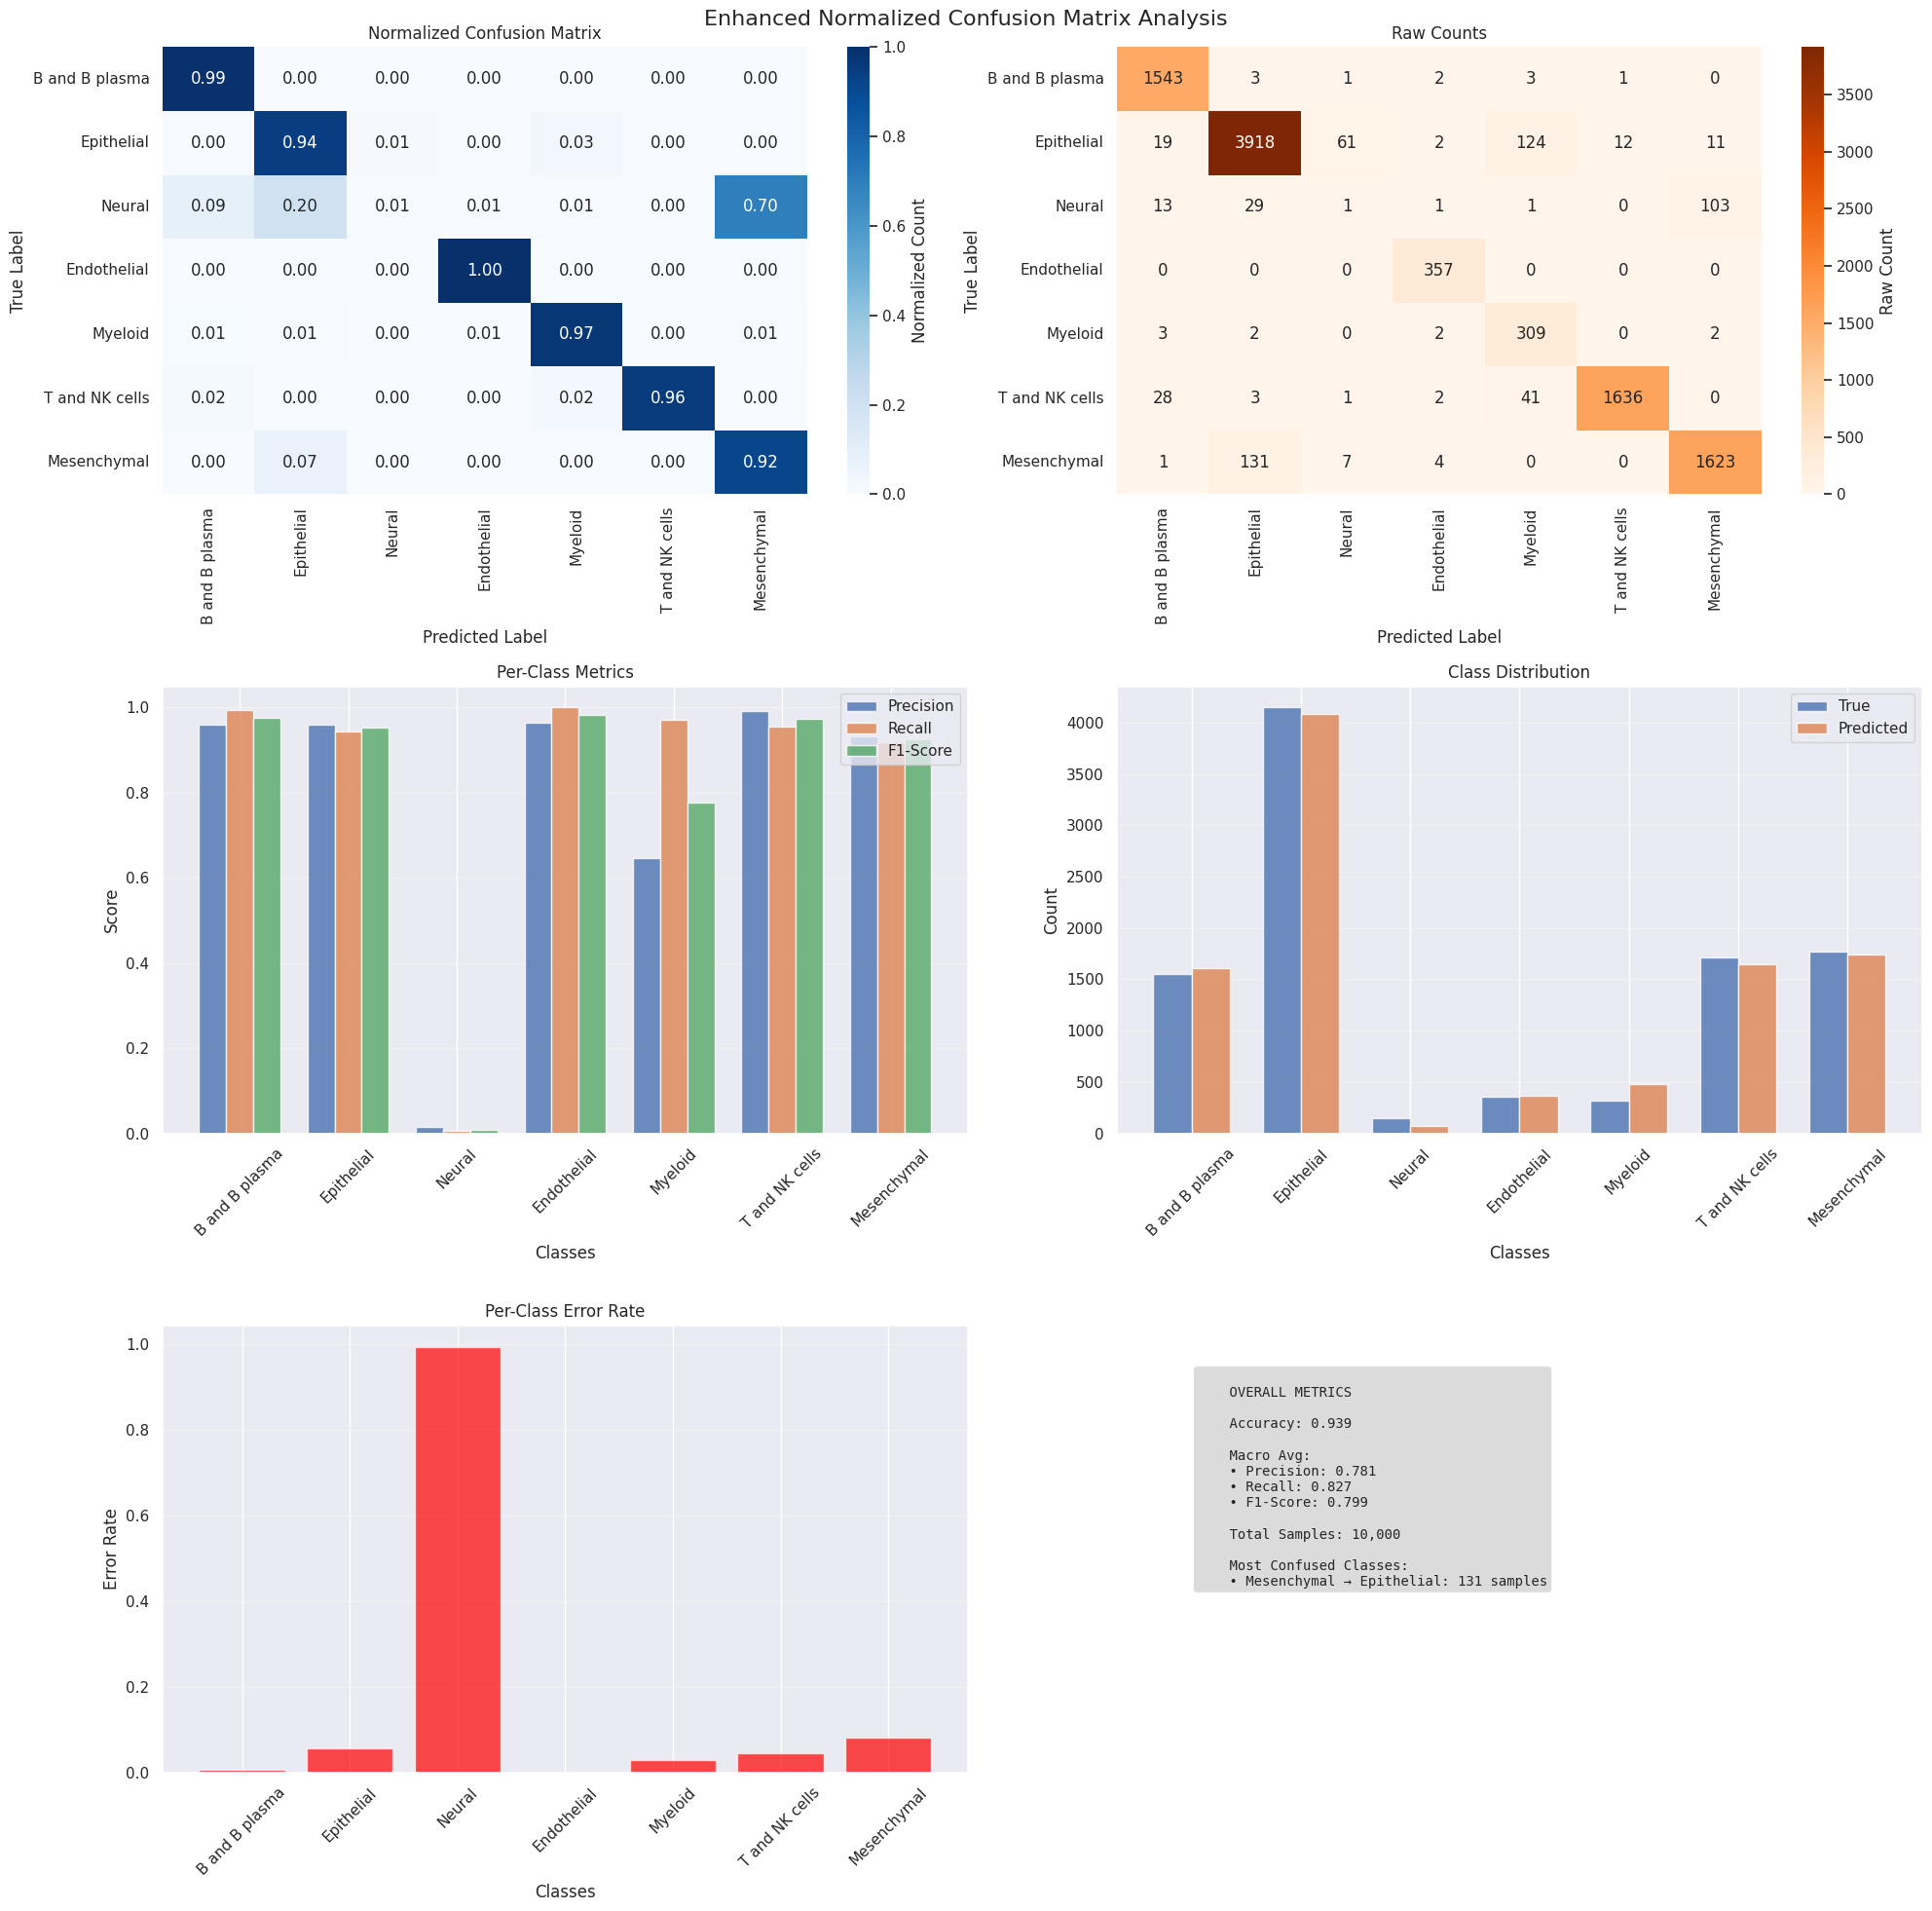


Detailed Classification Report:
                precision    recall  f1-score   support

B and B plasma       0.96      0.99      0.98      1553
    Epithelial       0.96      0.94      0.95      4147
        Neural       0.01      0.01      0.01       148
   Endothelial       0.96      1.00      0.98       357
       Myeloid       0.65      0.97      0.78       318
T and NK cells       0.99      0.96      0.97      1711
   Mesenchymal       0.93      0.92      0.93      1766

      accuracy                           0.94     10000
     macro avg       0.78      0.83      0.80     10000
  weighted avg       0.94      0.94      0.94     10000



In [16]:
# This cell contains comprehensive functions for visualizing confusion matrices with multiple perspectives

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def plot_enhanced_confusion_matrix(y_true, y_pred, classes, normalize=False, 
                                 title=None, cmap=plt.cm.Blues, figsize=(20, 20)):
    """
    Enhanced confusion matrix with multiple subplots showing various metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the main confusion matrix
        title: Plot title
        cmap: Colormap for main confusion matrix
        figsize: Figure size
    """
    if not title:
        if normalize:
            title = 'Enhanced Normalized Confusion Matrix Analysis'
        else:
            title = 'Enhanced Confusion Matrix Analysis'
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure with 6 subplots (3x2 grid)
    fig = plt.figure(figsize=figsize)
    
    # 1. Main confusion matrix (top left)
    plt.subplot(3, 2, 1)
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(cm_normalized, index=classes, columns=classes)
        sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap, 
                   cbar_kws={'label': 'Normalized Count'})
        plt.title('Normalized Confusion Matrix')
    else:
        df_cm = pd.DataFrame(cm, index=classes, columns=classes)
        sns.heatmap(df_cm, annot=True, fmt='d', cmap=cmap,
                   cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 2. Raw counts (top middle) - always show raw counts
    plt.subplot(3, 2, 2)
    df_cm_raw = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(df_cm_raw, annot=True, fmt='d', cmap='Oranges',
               cbar_kws={'label': 'Raw Count'})
    plt.title('Raw Counts')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 3. Per-class metrics bar plot (top right)
    plt.subplot(3, 2, 3)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    x = np.arange(len(classes))
    width = 0.25
    
    # Create grouped bar chart for precision, recall, and F1-score
    plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
    plt.bar(x, recall, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Metrics')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 4. Class distribution comparison (bottom left)
    plt.subplot(3, 2, 4)
    true_counts = pd.Series(y_true).value_counts().sort_index()
    pred_counts = pd.Series(y_pred).value_counts().reindex(true_counts.index, fill_value=0)
    
    x = np.arange(len(classes))
    width = 0.35
    
    # Compare true vs predicted class distributions
    plt.bar(x - width/2, true_counts.values, width, label='True', alpha=0.8)
    plt.bar(x + width/2, pred_counts.values, width, label='Predicted', alpha=0.8)
    
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 5. Error analysis (bottom middle)
    plt.subplot(3, 2, 5)
    # Calculate per-class error rates
    error_rates = []
    for i, class_name in enumerate(classes):
        true_positives = cm[i, i]
        total_true = cm[i, :].sum()
        error_rate = (total_true - true_positives) / total_true if total_true > 0 else 0
        error_rates.append(error_rate)
    
    plt.bar(classes, error_rates, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Error Rate')
    plt.title('Per-Class Error Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Summary statistics (bottom right)
    plt.subplot(3, 2, 6)
    plt.axis('off')
    
    # Calculate overall metrics
    accuracy = np.trace(cm) / np.sum(cm)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    # Create summary text with key metrics
    summary_text = f"""
    OVERALL METRICS
    
    Accuracy: {accuracy:.3f}
    
    Macro Avg:
    • Precision: {macro_precision:.3f}
    • Recall: {macro_recall:.3f}
    • F1-Score: {macro_f1:.3f}
    
    Total Samples: {np.sum(cm):,}
    
    Most Confused Classes:
    """
    
    # Find most confused class pair (highest off-diagonal value)
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    max_confusion_idx = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
    if cm_no_diag[max_confusion_idx] > 0:
        summary_text += f"• {classes[max_confusion_idx[0]]} → {classes[max_confusion_idx[1]]}: {cm_no_diag[max_confusion_idx]} samples"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=classes))

def plot_confusion_matrix_comparison(y_true, y_pred, classes, figsize=(20, 4)):
    """
    Plot multiple confusion matrix views side by side for comprehensive analysis
    
    Args:
        y_true: True labels
        y_pred: Predicted labels  
        classes: List of class names
        figsize: Figure size for the 4-panel comparison
    """
    cm = confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # 1. Raw counts - absolute numbers
    df_cm_raw = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(df_cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Raw Counts')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # 2. Normalized by row (shows recall per class)
    cm_norm_row = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm_row = pd.DataFrame(cm_norm_row, index=classes, columns=classes)
    sns.heatmap(df_cm_norm_row, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
    axes[1].set_title('Normalized by Row (Recall)')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    # 3. Normalized by column (shows precision per class)
    cm_norm_col = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    df_cm_norm_col = pd.DataFrame(cm_norm_col, index=classes, columns=classes)
    sns.heatmap(df_cm_norm_col, annot=True, fmt='.2f', cmap='Oranges', ax=axes[2])
    axes[2].set_title('Normalized by Column (Precision)')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')
    
    # 4. Percentage of total (shows relative frequency)
    cm_norm_total = cm.astype('float') / cm.sum()
    df_cm_norm_total = pd.DataFrame(cm_norm_total, index=classes, columns=classes)
    sns.heatmap(df_cm_norm_total, annot=True, fmt='.2f', cmap='Purples', ax=axes[3])
    axes[3].set_title('Percentage of Total')
    axes[3].set_ylabel('True Label')
    axes[3].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
plot_enhanced_confusion_matrix(labels, preds, types, normalize=True)

# UMAP Visualization of Cell Embeddings and Predictions

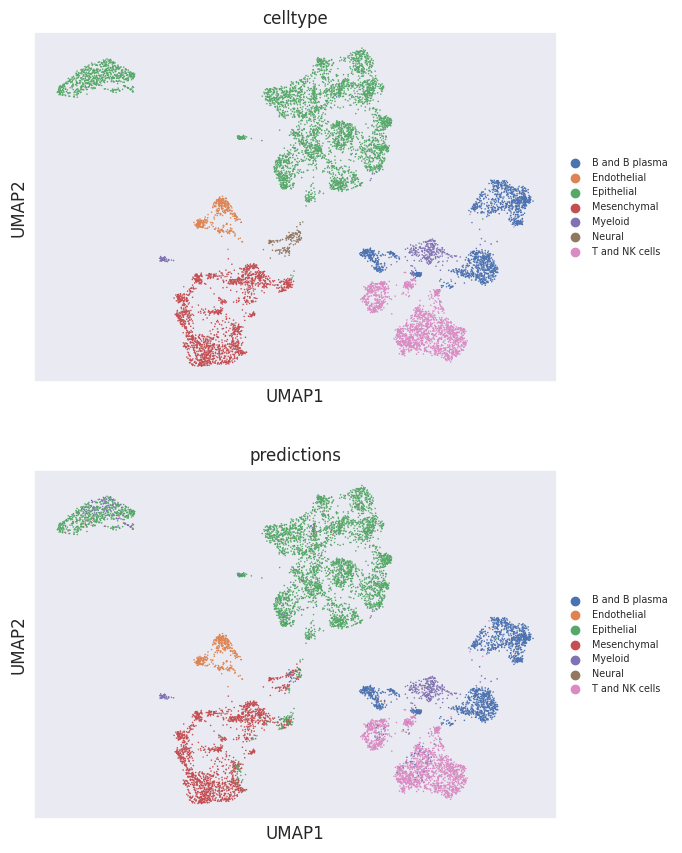

In [14]:
# This cell creates an AnnData object from cell embeddings and visualizes true vs predicted cell types

# Create AnnData object from cell embeddings for single-cell analysis
cell_embs_ad = ad.AnnData(cell_embs.numpy())

# Add metadata: true cell types from original dataset
cell_embs_ad.obs['celltype'] = dataset_sub['celltype']

# Add batch information if available (important for batch effect analysis)
if 'batch' in dataset_sub.features.keys():
    cell_embs_ad.obs['batch'] = dataset_sub['batch']
    cell_embs_ad.obs['batch'] = cell_embs_ad.obs['batch'].astype(str)

# Add predicted cell types (convert numerical predictions back to cell type names)
cell_embs_ad.obs['predictions'] = [types[i] for i in preds]

# Compute neighborhood graph for UMAP embedding
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=80)

# Generate UMAP embedding for 2D visualization
sc.tl.umap(cell_embs_ad)

# Create comparative UMAP plots showing true vs predicted cell types
sc.pl.umap(cell_embs_ad, 
           color=['celltype', 'predictions'],  # Show both true and predicted labels
           legend_fontsize='xx-small',         # Compact legend for many cell types
           size=5,                             # Point size
           legend_fontweight='light',          # Light font weight for readability
           ncols=1                            # Single column layout for comparison
          )

## It is evident that the cell embeddings generated directly by LangCell, without any fine-tuning, possess desirable properties: they cluster by cell type and eliminate batch effects. By comparing the left and middle plots, one can intuitively observe that LangCell is capable of reliably annotating cell types in a zero-shot scenario.
